In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('data/california_housing_prices.csv')

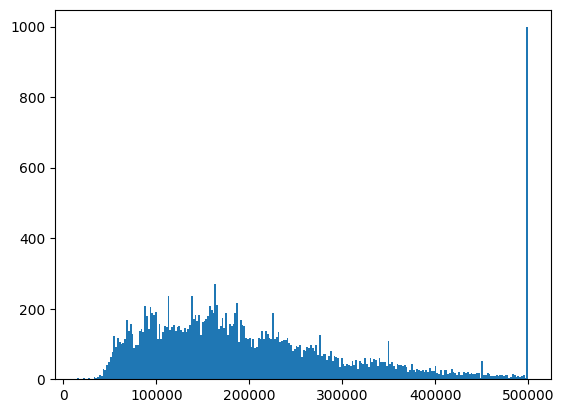

In [15]:
plt.hist(df['median_house_value'], bins=250)
plt.show()

**Observation:** `median_house_value` has a long tail.

In [16]:
df = df[(df['ocean_proximity']=='<1H OCEAN') | (df['ocean_proximity']=='INLAND')][['latitude', 'longitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']]

In [17]:
df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


In [18]:
# q1: which feature has missing values?
for i in ['total_rooms', 'total_bedrooms', 'population', 'households']:
    if (df[i].isnull().values.any()):
        print(i + " has missing values.")

total_bedrooms has missing values.


In [19]:
# q2: median of the variable 'population'
df['population'].median()

1195.0

In [20]:
# prepare and split the dataset
n = len(df)

np.random.seed(42)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_test + n_val)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()
df_val = df_shuffled.iloc[n_train+n_val:].copy()

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [21]:
y_train_orig = df_train.median_house_value.values
y_test_orig = df_test.median_house_value.values
y_val_orig = df_val.median_house_value.values

# apply log transformation
y_train = np.log1p(y_train_orig)
y_test = np.log1p(y_test_orig)
y_val = np.log1p(y_val_orig)

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

In [22]:
# linear regression function

def train_linear_regression(X,y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [35]:
#q3: better RMSE

# method 1: replace with 0

def prepare_X_0(df):
    df_num = df['total_bedrooms']
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [36]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [47]:
X_train = prepare_X_0(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + (X_train * w)
print('train', round(rmse(y_train, y_pred),2))

X_val = prepare_X_0(df_val)
y_pred = w_0 + (X_val * w)
print('validation', round(rmse(y_val, y_pred),2))

train 0.56
validation 0.56


In [43]:
# method 2: replace with mean

def prepare_X_mean(df):
    df_num = df['total_bedrooms']
    df_num = df_num.fillna(df['total_bedrooms'].mean())
    X = df_num.values
    return X

In [48]:
X_train = prepare_X_mean(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + (X_train * w)
print('train', round(rmse(y_train, y_pred),2))

X_val = prepare_X_mean(df_val)
y_pred = w_0 + (X_val * w)
print('validation', round(rmse(y_val, y_pred),2))

train 0.56
validation 0.56


In [49]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [56]:
# q4
X_train = prepare_X_0(df_train)
X_val = prepare_X_0(df_val)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + (X_val * w)
    print('%6s' %r, rmse(y_val, y_pred))
    


     0 0.5580306816468477
 1e-06 0.5580306816786674
0.0001 0.5580306848288559
 0.001 0.5580307134700196
  0.01 0.5580310001876152
   0.1 0.5580338979577594
     1 0.5580659332604598
     5 0.558275368341857
    10 0.5586901438509507


In [65]:
# q5
scores = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_test + n_val)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()
    df_val = df_shuffled.iloc[n_train+n_val:].copy()

    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    df_val.reset_index(drop=True, inplace=True)

    y_train_orig = df_train.median_house_value.values
    y_test_orig = df_test.median_house_value.values
    y_val_orig = df_val.median_house_value.values

    # apply log transformation
    y_train = np.log1p(y_train_orig)
    y_test = np.log1p(y_test_orig)
    y_val = np.log1p(y_val_orig)

    del df_train['median_house_value']
    del df_test['median_house_value']
    del df_val['median_house_value']

    X_train = prepare_X_0(df_train)
    w_0, w = train_linear_regression(X_train, y_train)

    # y_pred = w_0 + (X_train * w)
    # print('train', rmse(y_train, y_pred))

    X_val = prepare_X_0(df_val)
    y_pred = w_0 + (X_val * w)
    scores.append(rmse(y_val, y_pred))
    # print('validation', rmse(y_val, y_pred))

print(round(np.std(scores),3))

0.008


In [71]:
# q5

np.random.seed(9)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_test + n_val)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_test = df_shuffled.iloc[n_train:n_train+n_test].copy()
df_val = df_shuffled.iloc[n_train+n_val:].copy()
df_combine = df_train + df_val

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_combine.reset_index(drop=True, inplace=True)

# y_train_orig = df_train.median_house_value.values
y_test_orig = df_test.median_house_value.values
y_combine_orig = df_combine.median_house_value.values
# y_val_orig = df_val.median_house_value.values

# apply log transformation
# y_train = np.log1p(y_train_orig)
y_test = np.log1p(y_test_orig)
y_combine = np.log1p(y_combine_orig)
# y_val = np.log1p(y_val_orig)

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']
del df_combine['median_house_value']

X_combine = prepare_X_0(df_combine)
w_0, w = train_linear_regression(X_combine, y_combine)

y_pred = w_0 + (X_combine * w)
print('train', rmse(y_combine, y_pred))

X_test = prepare_X_0(df_test)
y_pred = w_0 + (X_test * w)
print('test', rmse(y_test, y_pred))

train nan
test nan
